# Hamiltonian ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

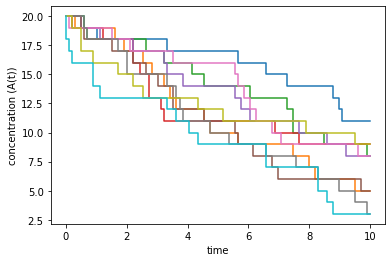

In [2]:
np.random.seed(3)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using Rejection ABC

The Rejection ABC algorithm can be applied to sample parameter values. An error measure will be used to compare the difference between the stochastic simulation obtained with the true set of parameters and the stochastic simulation obtained with a candidate value. Our error measure of choice is the root mean squared error. Root mean squared error has been chosen in order to amplify smaller differences between two stochastic simulations in order to increase the quality of our samples.

In [10]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.HamiltonianABC)


def sim_f(theta):
    if len(theta.shape) == 2:
        theta = theta[0]
    # print("theta"+str(theta)+", times="+str(times))
    return model.simulate(theta, times)

# Set the simulating function
abc.sampler().set_sim_f(sim_f)

# set starting point
abc.sampler().set_theta0([0.15])

# present data
abc.sampler().set_y(values)

abc.set_parallel(True)

# set threshold
abc.sampler().set_threshold(0.000001)

# set target number of samples
abc.set_n_samples(100)

# set number of leapfrog steps
abc.sampler().set_m(10)

# set S and R
abc.sampler().set_R(10)
abc.sampler().set_S(1)

# set d_theta
abc.sampler().set_d_theta(0.01)

# Set step size
abc.sampler().set_step_size(0.0015)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Hamiltonian ABC
Running in parallel with 8 worker processess.
Iter. Eval. Acceptance rate Time m:s
1     8      1                0:18.1
2     16     0.9375           0:41.2
3     24     0.916666667      1:00.5
Halting: target number of samples (106) reached.
Done


In order to find the efficiency of the rejection ABC, we plot the approximate posterior compared to the actual parameter value. In the graph, we can see that there is a high concentration of samples around the value with which the data was generated. This suggests that the rejection ABC algorithm performs well and that the root mean squared error was a good choice as an error measure, since high quality samples were produced.

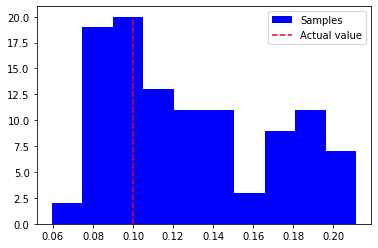

In [12]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=20, label="Actual value", color="red")
plt.legend()
plt.show()

# Note on Rejection ABC

The Rejection ABC algorithm is a highly simplistic method for Bayesian inference. As a consequence, it is inefficient when used with high variance priors.

Please make sure that you are monitoring the acceptance rate to see if this algorithm is working for your problem.